In [16]:
import numpy as np
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema

class potencial_datos:
    
    def __init__(self, N=10):
        self.N = N

    def I_nmr(self,n, m, r):
        if r<0 or n<0 or m<0:
            return 0
        if r==0:
            if n==m:
                return np.sqrt(np.pi)*2**n*factorial(n)
            else:
                return 0
        return 1./2*self.I_nmr(n+1,m,r-1) + n*self.I_nmr(n-1,m,r-1)

    def C_nm(self, n, m, alphas):
        An = 1./np.sqrt(np.sqrt(np.pi)*factorial(n)*2**n)
        Am = 1./np.sqrt(np.sqrt(np.pi)*factorial(m)*2**m)
        I1 = -1/2*self.I_nmr(n,m,2)
        I2 = 1/2*self.I_nmr(n,m,0)
        I3 = 2*m*self.I_nmr(n,m-1,1)
        I4 = -2*m*(m-1)*self.I_nmr(n, m-2,0)
        Iv = 0
        for i in range(len(alphas)):
            Iv+=alphas[i]*self.I_nmr(n,m,i)
        return An*Am*(I1+I2+I3+I4+Iv)

    def Calcular_energia_alpha_minimo(self, alphas, estado_n=0):
        N = self.N
        # Generando la matriz C_nm
        C = np.zeros((N,N))
        for n in range(N):
            for m in range(N):
                C[n,m] = self.C_nm(n,m,alphas)

        # Generando la matriz D
        D = np.zeros((N,N))
        for n in range(N):
            for m in range(n+1):
                D[n,m] = C[n,m] + C[m,n]
                D[m,n] = D[n,m]

        # Diagonalizando la matriz D
        vaps, veps = eigh(D)

        # Calcular <H> 
        Hs = np.zeros(N)
        for i in range(N):
            a = veps[:, i]
            for n in range(N):
                for m in range(N):
                    Hs[i]+=a[n]*a[m]*C[n,m]

        # 4. We choose the vector which minimizes <H>
        # If n_state!=0, we choose the vector with n_state-th lowest energy
        # as an approximation of the n_state excited state 
        sel = np.argsort(Hs)[estado_n] #np.argmin(Hs)
        a = veps[:, sel] # Final value of eigenvalues for state n_state
        E_a = Hs[sel] # Value of the energy
        return E_a, a

    def HO_wavefunction(self, n, xmin, xmax, n_points):
        x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
        herm = eval_hermite(n, x) # H_n(x)
        exp = np.exp(- x**2/2) # Exponential term
        phi_n = exp*herm

        # Normalization
        h = (xmax - xmin)/n_points
        C = 1./np.sqrt(np.sum(phi_n*phi_n*h))
        phi_n = C*phi_n
        
        return phi_n

    def final_wavefunction(self, xmin, xmax, n_points, a_s):
        x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
        n_samples, _ = a_s.shape
        # Construct matrix of phi_n
        phis = np.zeros((self.N, n_points))

        for i in range(N):
            phis[i,:] = self.HO_wavefunction(i, xmin, xmax, n_points)

        waves = np.zeros((n_samples, n_points))
        for i in range(n_samples):
            for j in range(n_points):
                waves[i,j] = np.dot(a_s[i,:],phis[:,j])
            # convention: To choose the phase we make the maximums be first
            w = waves[i,:]
            maxi = argrelextrema(w, np.greater)[0] #array con indices de maximos localles de w
            mini = argrelextrema(w, np.less)[0]    #array con indices de minimos localles de w
            idx2= np.abs(w[maxi])>5e-2 
            maxi = maxi[idx2] #idices con valores absolutos maximos de la funcion wave > 0.05
            idx2= np.abs(w[mini])>5e-2 
            mini = mini[idx2] #idices con valores absolutos minimos de la funcion wave > 0.05
            if len(maxi)==0 and len(mini)>0:
                waves[i,:] = -waves[i,:]
            elif len(mini)>0 and len(maxi)>0 and mini[0]<maxi[0]:
                waves[i,:] = -waves[i,:]
        return waves, x, phis

    def evaluar_potencial(self, xmin, xmax, n_points, n_alphas):
        x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
        n_samples, k = n_alphas.shape
        V = np.zeros((n_samples, n_points))
        x_mat = (x**np.arange(k)[:,None])# Matrix of powers of x: x^0, x^1, x^2, ..., x^N (in every row)
        V = np.zeros((n_samples, n_points))# V(x) in each row different alpha
        for i in range(n_samples):
            for j in range(n_points):
                V[i,j] = np.dot(n_alphas[i,:],x_mat[:,j])
        return V, x

# Generando datos

In [17]:
arr = np.array([1, 2, 3, 4])
potencial = potencial_datos()

E_min, a_min = potencial.Calcular_energia_alpha_minimo(arr)
print('Energia minima = {}'.format(E_min))
print('alphas optimos = {}'.format(a_min))

Energia minima = -146.43980181452912
alphas optimos = [-0.00148757  0.0074776  -0.02521254  0.06472122 -0.14123875  0.26127523
 -0.3874771   0.4957376  -0.57880511  0.41951711]


### Energia minima y los coeficientes optimos para la funcion de onda de cada ejemplo

In [45]:
n_ejemplos = 100
alpha_min = np.array([-4.5, -0.65, 0.2, -0.01, 0])
alpha_max = np.array([1.5, 0.65, 1, 0.01, 0.1])
k = len(alpha_min)
estado_n = 1
N = 10

r_alpha = np.random.random((n_ejemplos, k))
n_alphas = r_alpha*(alpha_max - alpha_min)+ alpha_min # random alpha
E_mins = np.zeros(n_ejemplos)
a_mins = np.zeros((n_ejemplos, N))

for i in range(n_ejemplos):
    E_min, a_min = potencial.Calcular_energia_alpha_minimo(n_alphas[i,:], estado_n)
    E_mins[i] = E_min
    a_mins[i,:] = a_min
print('E shape = {}'.format(E_mins.shape))
print('a shape = {}'.format(a_mins.shape))

E shape = (100,)
a shape = (100, 10)


### Funciones de onda para cada ejemplo

In [46]:
x_min = -5
x_max = 5
n_points = 100

waves, x, phis = potencial.final_wavefunction(x_min, x_max, n_points, a_mins)

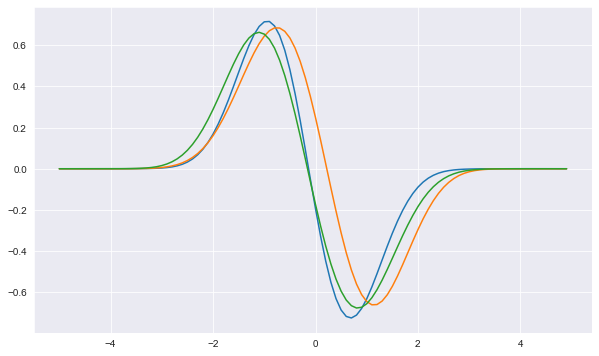

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
for i in range(3):
    sns.lineplot(x = x, y = waves[i,:])

### Potenciales para cada ejemplo

In [55]:
V, x = potencial.evaluar_potencial(x_min, x_max, n_points, n_alphas)
("V shape = {}".format(V.shape))

'V shape = (100, 100)'

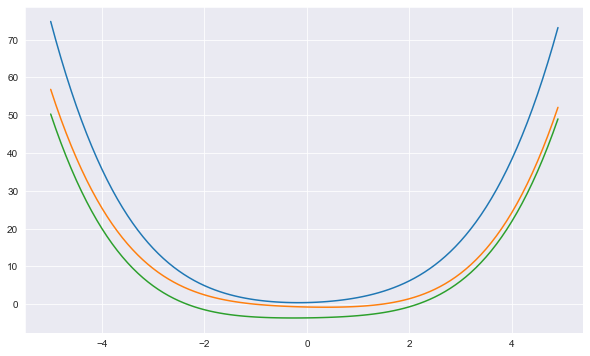

In [52]:
plt.figure(figsize=(10,6))
for i in range(3):
    sns.lineplot(x = x, y = V[i,:])
